# Programación Entera: Heurísticas para Problemas de Redes

## Descripción

En este trabajo se estudian distintos problemas de redes de manera detallada, en concreto el de flujo de redes con costos fijos, el árbol recubridor mínimo, el árbol recubridor mínimo capacitado y el problema de Steiner. Todo ello se ha hecho apoyandose en el lenguaje *R* y los solvers *glpk* y *xpress-mosel*. Por último se ha comprobado la validez de los métodos sobre distintos problemas a modo de ejemplo.

Este documento forma parte de un grupo de trabajos relacionados con la heuristicas para la resolución de problemas de programación entera. Existen otros tres trabajos referidos al estudio del [problema de la asignación](https://nbviewer.jupyter.org/github/garciparedes/integer-programming-heuristics/blob/master/integer-programming-assignment-heuristics.ipynb), al [problema de la mochila](https://nbviewer.jupyter.org/github/garciparedes/integer-programming-heuristics/blob/master/integer-programming-knapsack-heuristics.ipynb) y a [problemas de localización de servicios](https://nbviewer.jupyter.org/github/garciparedes/integer-programming-heuristics/blob/master/integer-programming-service-location-heuristics.ipynb). El contenido completo del trabajo está publicado en el siguiente repositorio: https://github.com/garciparedes/integer-programming-heuristics

## Autor
  
  * Sergio García Prado - [garciparedes.me](https://garciparedes.me)
  
## Fecha

  * Mayo de 2018


## Contenidos
  
  * [Introducción](#Introducción)
  * [Problemas De Redes](#Problemas-de-Redes)
    * [Flujo de Redes con Costes Fijos](#Flujo-de-Redes-con-Costes-Fijos)
    * [Árbol Recubridor Mínimo](#Árbol-Recubridor-Mínimo)
    * [Árbol Recubridor Mínimo Capacitado](#Árbol-Recubridor-Mínimo-Capacitado)
    * [Problema de Steiner](#Problema-de-Steiner)
  * [Conclusiones](#Conclusiones)

## Introducción

El estudio de problemas basados en estructuras en forma de red representan un área de estudio de vital importancia por su gran capacidad de modelización y aplicación en problemas reales. Este tipo de problemas se caracterizan por dicha estructura en forma de red o grafo. 

Dichas estructuras denominadas *grafo* se caracterizan de la siguiente manera: están formadas por un conjunto de vértices o puntos, los cuales denotaremos por $V = \left\{1, ..., n \right\}$, que se relacionan entre si dos a dos mediante un conjunto de arcos o aristas, los cuales representaremos mediante tuplas y denotaremos por $E = \left\{(i_{1}, j_{1}), ..., (i_{m}, i_{m})\right\}$. Tal y como vemos, el conjunto de vértices será de tamaño $n$ y el de aristas de tamaño $n$. Dichas aristas pueden ser dirigidas (donde el orden $(i, j)$) importa, en cuyo caso $m \leq n ^ 2 - n$, o no dirigidas (donde el orden no importa), en cuyo caso $m \leq \frac{n ^ 2 - n}{2}$. Por tanto, podemos denotar un grafo cualquiera como la tupla formada por el conjunto de sus vértices, y el de sus aristas. Esto es: 

$$G = \left(V, E\right)$$

Por tanto, los problemas de redes se caracterizan por estar basados en la búsqueda de la configuración óptima en algún sentido de la estructura del grafo. Tal y como se puede apreciar, mediante la modelización de grafo existen muchas carácterísticas que pueden ser optimizadas, tales como caminos más cortos entre dos puntos, el conjunto de aristas que recubra todo el conjunto de vértices de menor tamaño, etc.

En este trabajo, se van a estudiar cuatro tipos de problemas: *flujo de redes de costes fijos* (basado en encontrar la red de transporte de productos que minimice los costes, *el árbol recubridor mínimo* (el conjunto de aristas de longitud mínima que interconecta todos los vértices) así como su versión con restricciones de *capacidad*. Por último, estudiaremos el problema de *Steiner* (conjunto de aristas que interconectan un subconjunto de los vértices del grafo, de manera mínima). 

Para estos problemas, se estudiará el contexto de los mismos, así como la problemática que estos son capaces de resolver. Además, se definirá el modelo de programación lineal que los resuelve junto con la implementación adecuada en *r* (mediante el solver *glpk* cuando sea posible) y en *xpress mosel* para el resto de casos. Posteriormente, se validan las implementaciones realizadas sobre un grupo de problemas de ejemplo. Finalmente, se discuten distintas ideas acerca de este tipo de problemas en la sección de conclusiones

#### Configuración del Entorno

A continuación se aplican distintas configuraciones sobre el entorno de desarrollo, tales como importación de paquetes:

In [1]:
rm(list = ls())

In [2]:
library(slam, warn.conflicts = FALSE)
library(Rglpk, warn.conflicts = FALSE)
library(purrr, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(magrittr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggthemes, warn.conflicts = FALSE)
library(scales, warn.conflicts = FALSE)
library(igraph, warn.conflicts = FALSE)
library(gridExtra, warn.conflicts = FALSE)

Using the GLPK callable library version 4.65


In [3]:
options(repr.matrix.max.rows = 600, repr.matrix.max.cols = 600)

#### Constantes y Funciones de Apoyo

Lo siguiente es definir ditintas constantes basadas en la localización de los conjuntos de datos que se utilizarán como ejemplo, así como algunas funciones de apoyo que simplificarán distintas situaciones como importación de datos u otras tareas:

In [4]:
dataset.root <- "./data/"
dataset.folder <- paste0(dataset.root, "network/")
dataset.mosel <- paste0(dataset.folder, "mosel/")

In [5]:
gr.15 <- c("gr15_1", "gr15_2", "gr15_3", "gr15_4", "gr15_4" )

In [6]:
Solve <- function(...) {
    Rglpk_solve_LP(...)
}

In [7]:
ReadRaw <- function(file.path) {
    con <- 
        file.path %>%
        file(open = "r")
    raw <- 
        con %>%
        readLines(warn = FALSE) %>% 
        strsplit("[[:blank:]]+") %>%
        unlist() %>%
        as.double()
    close(con)
    return(raw)
}

In [8]:
Format1DFixedCostNetworkSolution <- function(s, p, with.edges = FALSE) {
    if (length(s$solution) %% p$n == 0) {
        n <- p$n 
    } else {
        n <- p$n + 1
    }
    l <- list(
        min.cost = s$optimum,
        quantity = matrix(s$solution[1:(n ^ 2)], ncol = n, byrow = TRUE)   
    )
    if (with.edges) {
        l$edge <- matrix(s$solution[(n ^ 2 + 1):(2 * n ^ 2)], ncol = n, byrow = TRUE)
    }
    if (length(a$solution) > (2 * n ^ 2)) {
        l$node <- matrix(s$solution[(2 * n ^ 2 + 1):(2 * n ^ 2 + n)], ncol = n, byrow = TRUE)
    }
    return(l)
}

In [9]:
ReadCoordinatedFile <- function(file.path) {
    raw <- 
        file.path %>%
        ReadRaw()
    a <- matrix(0, nrow = raw[1], ncol = 2)
    a[, 1] <- raw[1 + seq(2, to = length(raw), by = 3)]
    a[, 2] <- raw[1 + seq(3, to = length(raw), by = 3)]
    
    return(a)
} 

In [10]:
DenseToA <- function(dense) {
    A = matrix(0, ncol = 5, nrow = (ncol(dense)) ^ 2 - ncol(dense))
    k <- 1
    for (i in 1:(ncol(dense) - 1)) {
        for (j in (i + 1):(ncol(dense))) {
            A[k, ] <- c(i, j, dense[i, j], 0, ncol(dense))
            A[k + 1, ] <- c(j, i, dense[i, j], 0, ncol(dense))
            k <- k + 2
        }   
    }
    A
}

In [11]:
WriteListToMoselData <- function(file.path, p) {
    s <- ""
    for(i in 1:length(p)) {
        s <- paste0(s, names(p)[i],": ")
              
        if (is.vector(p[[i]])) {
            s <- paste0(s, p[[i]])
        } else {
            s <- paste0(s, "[", paste(round(t(p[[i]]), digits = 4), collapse=' '), "]")
        } 
        s <- paste0(s, '\n')
    }
    
    fileConn <- file(file.path)
    writeLines(s, fileConn)
    close(fileConn)
}

In [12]:
ReadEdgesList <- function(file.path) {
    read.csv(file.path, header  = TRUE)
}

## Problemas de Redes

Los problemas de redes son todos aquellos problemas de optimización (lineal o no lineal) aplicables sobre estructuras en forma de redes (grafos). La mayoría de estos se basan en la búsqueda de la mejor interconexión del conjunto de vértices (o de un subconjunto del mismo como veremos en el caso del problema de *steiner*) de tal manera que se optimice una determinada métrica. Uno de los problemas con mayor capacidad de modelización es el problema del flujo de redes con costes fijos, que a pesar de su simplicidad tiene un gran potencial. Por tanto, será el primero que estudiaremos.

### Flujo de Redes con Costes Fijos

#### Descripción

El problema de flujo de redes de costes fijos se basa en lo siguiente. Suponemos un grafo que modeliza una determinada red de interconexiones entre distintos vértices. Estos tienen distintos requisitos de ofertas y demandas, por tanto, es necesario encontrar el subconjunto de aristas que permite satisfacer las necesidades de cada vértices, minimizando los costes de operaciones. Dichos costes pueden ser de dos tipos: fijos (referidos a la utilización o no de un determinado arista) y los variables (referidos a la cantidad de producto que se transportará por una determinada arista. Además, en algunas ocasiones existen distintas restricciones en cuanto a la capacidad de las distitnas aristas.

Para modelizar dicha situación matemáticamente, debemos realizar unas pequeñas modificaciones sobre el problema. En primer lugar, deberemos imponer la restricción de que el total de oferta para un determinado producto sea equivalente al total de demanda del mismo. En caso de que esta no sea la misma, tendreos que crear un vértice ficticio que emule el la demanda sobrante (o la oferta restante).

Una vez aplicados dichos ajustes, modelizaremos el problema de la siguiente manera: utilizaremos un vector $b$ de longitud $n$ que contenga las ofertas y demandas (con signo negativo) de los distintos productos. Además, almacenaremos los costes fijos de utilización de una determinada arista en una matriz $F$ de cuadrada de $n$ filas y $n$ columnas. Los costes variables los representaremos por la matriz $C$. Por último, la matriz $U$ cuadrada y de $n$ filas y $n$ columnas representará la cantidad máxima de producto que podrá ser transportada por un determinado arista. Para resolver el problema, necesitaremos dos conjuntos de variables de decisión el primero e ellos estará formado por una matriz $Y$ de carácter binario formada por $n$ filas y $n$ columnas que representará la utilización o no de un determinado arista (para calcular costes fijos). El segundo conjunto de variables de decisión será de carácter continuo positivo, y lo representaremos por la matriz $X$ de $n$ filas y $n$ columnas. Este segundo conjunto representará la cantidad de producto que fluye por el arista que conecta el vértice $i$ con el $j$.

Nótese que muchos grafos tienen una estructura extremadamente dispersa, donde cada vértice se interconecta con un subconjunto muy pequeño de vecinos. Por tanto, a pesar de que en este caso, el problema ha sido modelizado a partir de matrices (convenientes para problemas sobre grafos completos), en el resto de casos se producirá una extremada ineficiencia a nivel de espacio por utilizar estas estructuras. En dichos casos, la mejor alternativa es la utilización de matrices dinámicas o dispersas.

#### Modelo

A continuación se define el modelo descrito en el párrafo anterior:

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{(i,j) \in A}\left(f_{ij} \cdot y_{ij} + c_{ij} \cdot x_{ij}\right) \\
      \text{sujeto a}  & \sum\limits_{j} x_{ij} - \sum\limits_{j} x_{ji} = b_{i}, & \forall i \in N \\
                       & x_{ij} \leq u_{ij} \cdot y_{ij},  & \forall (i,j) \in A \\
                       & x_{ij} \geq 0, & \forall (i,j) \in A \\
                       & y_{ij} \in \{0, 1\},  & \forall (i,j) \in A
    \end{array}
\end{equation}

La implementación del modelo en el lenguaje *r* se muestra a continuación:

In [13]:
Solve1DFixedCostNetworkExact <- function(p) {
    eq <- sum(p$b)
    if (eq != 0) {
        p$n <- p$n + 1
        p$b <- rbind(p$b, - eq)
        p$A <- rbind(p$A, (cbind(seq(1, p$n - 1), p$n, 0, 0, eq)))
        if (!is.null(p$F)) {
            p$F <- rbind(p$F, 0)
        }
    } 
    obj <- rep(0, 2 * (p$n ^ 2))
    conditions <- matrix(0, nrow = p$n + nrow(p$A), ncol = 2 * (p$n ^ 2))
    for (i in 1:p$n) {
        conditions[i, (i - 1) * p$n + p$A[which(p$A[,1] == i), 2, drop = FALSE]] <-  1
        conditions[i, p$n * (p$A[which(p$A[,2] == i), 1, drop = FALSE] - 1) + i] <- -1
    }
    for (i in 1:nrow(p$A)) {
        conditions[i + p$n, (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- 1
        conditions[i + p$n, p$n ^ 2 + (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- - p$A[i, 5]        
        obj[(p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- p$A[i, 4]
        obj[p$n ^ 2  + (p$A[i, 1] - 1) * p$n + p$A[i, 2]] <- p$A[i, 3]
    }
    rhs <- c(p$b, rep(0, nrow(p$A)))
    dir <- rep(c("==", "<="), c(p$n, nrow(p$A)))
    types <- rep(c("C", "B"), c(p$n ^ 2 , p$n ^ 2))
    if (!is.null(p$F)) {
        obj <- c(obj, rep(0, p$n))
        obj[(2 * (p$n ^ 2) + 1):(2 * (p$n ^ 2) + p$n)] <- p$F
        cc <- matrix(0, nrow = p$n, ncol = 2 * (p$n ^ 2) + p$n)
        for (i in 1:p$n) {
            cc[i, p$n ^ 2 + p$n * (p$A[which(p$A[,2] == i), 1, drop = FALSE] - 1) + i] <- 1
            cc[i, p$n ^ 2 + p$n * (i - 1) + p$A[which(p$A[,1] == i), 2, drop = FALSE]] <- 1
            cc[i, 2 * p$n ^ 2 + i ] <-  - 2 * p$n
        }
        conditions <- cbind(conditions, matrix(0, nrow = p$n + nrow(p$A), ncol = p$n))
        conditions <- rbind(conditions, cc)
        rhs <- c(p$b, rep(0, nrow(p$A) + p$n))
        dir <- c(dir, rep("<=", p$n))
        types <- c(types, rep("B", p$n))
    }
    s <- Solve(obj = obj, mat = conditions, dir = dir, rhs = rhs, types = types)
    return(s)
}

#### Ejemplos

Para comprobar la validez del modelo, se ha resuelto un conjunto de problemas, para los cuales se presentan los resultados a continuación. Para simplificar la modelización, los dos últimos problemas han sido resueltos utilizando el solver *xpress mosel*, que permite el uso de variables directamente en forma matricial, lo cual simplifica extremadamente la modelización.

##### distribucion.gas

In [14]:
distribucion.gas <- 
    list(
        n = 5,
        b = matrix(c(800, 600, 0, 0, - 1400), ncol = 1),
        A = matrix(c(2, 1,  60 * 100000, 2000,  1000,
                     1, 3,  80 * 100000, 2000,  1000,
                     2, 3, 100 * 100000, 2000,  1000,
                     2, 4, 140 * 100000, 2000,  1000,
                     3, 4,  20 * 100000, 2000,  1000,
                     3, 5,            0, 2000,  1000,
                     4, 5,            0, 2000,  1000), 
                   ncol = 5, byrow = TRUE)
    )

In [15]:
a <- Solve1DFixedCostNetworkExact(distribucion.gas)
Format1DFixedCostNetworkSolution(a, distribucion.gas)

0,0,800,0,0
0,0,600,0,0
0,0,0,400,1000
0,0,0,0,400
0,0,0,0,0


##### aguas.residuales

In [16]:
aguas.residuales <- 
    list(
        n = 9,
        b = matrix(c(27, 3, 14, 36, 21, 8, 13, 0, -122), ncol = 1),
        A = matrix(c(1, 2,  240, 21, 122,
                     1, 3,  350, 30, 122,
                     2, 3,  200, 22, 122,
                     2, 4,  750, 58, 122,
                     3, 4,  610, 43, 122,
                     3, 9, 3800,  1, 122,
                     4, 3, 1850, 49, 122,
                     4, 8,  780, 63, 122,
                     5, 6,  620, 44, 122,
                     5, 7,  800, 51, 122,
                     6, 7,  500, 56, 122,
                     6, 8,  630, 94, 122,
                     7, 4, 1120, 82, 122,
                     7, 9, 3800,  1, 122,
                     8, 9, 2500,  2, 122),
                   ncol = 5, byrow = TRUE)
    )

In [17]:
a <- Solve1DFixedCostNetworkExact(aguas.residuales)
Format1DFixedCostNetworkSolution(a, aguas.residuales)

0,0,27,0,0,0,0,0,0
0,0,3,0,0,0,0,0,0
0,0,0,0,0,0,0,0,80
0,0,36,0,0,0,0,0,0
0,0,0,0,0,0,21,0,0
0,0,0,0,0,0,8,0,0
0,0,0,0,0,0,0,0,42
0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0


##### un.producto

In [18]:
un.producto <- list(
    n = 7,
    b = matrix(c(380, 450, 0, 0, -200, -250, -300), ncol = 1),
    F = matrix(c(0, 0, 50000, 70000, 0, 0, 0), ncol = 1),
    A = matrix(c(1, 3,  250, 45, 1000,
                 1, 5,  300, 35, 100,
                 2, 3,  150, 50, 1000,
                 2, 4,  200, 50, 1000,
                 3, 4,  150, 20, 100,
                 3, 5,  100, 40, 200,
                 3, 6,  200, 50, 1000,
                 3, 7,  200, 50, 1000,
                 4, 3,  150, 20, 100,
                 4, 6,  100, 60, 200,
                 4, 7,  150, 40, 300),
               ncol = 5, byrow = TRUE)
)

In [19]:
a <- Solve1DFixedCostNetworkExact(un.producto)
Format1DFixedCostNetworkSolution(a, un.producto)

0,0,280,0,100,0,0,0
0,0,370,0,0,0,0,80
0,0,0,0,100,250,300,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0
1,1,1,0,1,1,1,1


##### avicola

In [20]:
file.show(file = paste0(dataset.mosel, "avicola.mos"))

R Information

model "avicola"
    uses "mmxprs";
    declarations
        n: integer
        p: integer
        e: integer
        file_name = "avicola"
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        n p e
    end-initializations 
    declarations
        nodes = 1..n
        products = 1..p
        b: array(nodes, products) of real
        edges: array(1..e, 1..(3 + p)) of integer
        c: array(nodes, nodes, products) of real
        f: array(nodes, nodes) of real
        x: dynamic array(nodes, nodes, products) of mpvar
        y: dynamic array(nodes, nodes) of mpvar
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        b edges
    end-initializations 
    forall(ee in 1..e) do
        ii := edges(ee, 1)
        jj := edges(ee, 2)
        create(y(ii, jj))
        y(ii, jj) is_binary
        f(ii, jj) := edges(ee, 3)
        forall(k in products) do
            create(x(ii, jj, k))
            c(ii, jj

In [21]:
read.csv(paste0(dataset.mosel, "mosel_output_avicola.csv")) %>%
    tidyr::spread(key = "k", value = "quantity", fill = 0)

i,j,1,2,3,4
1,4,50,100,0,0
1,7,50,0,40,0
2,4,100,100,0,0
2,7,0,100,50,50
3,4,0,0,50,75
3,7,40,100,25,25
4,6,150,200,50,75


##### mercasol

In [22]:
file.show(file = paste0(dataset.mosel, "mercasol.mos"))

R Information

model "mercasol"
    uses "mmxprs";

    declarations
        n: integer
        m: integer
        p: integer
        file_name = "mercasol"
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        m n p
    end-initializations 
    declarations
        origins      = 1..m
        destinations = 1..n
        products      = 1..p
        costo_var: array(origins, destinations) of real
        costo_fijo: array(origins, destinations) of real
        cap: array(origins, destinations) of real
        ofe: array(origins, products) of real
        dem: array(destinations, products) of real
        x: array(origins, destinations) of mpvar
        y: array(origins, destinations, products) of mpvar
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        costo_var costo_fijo cap ofe dem
    end-initializations
    forall(i in origins, j in destinations) do
        x(i, j) is_binary
    end-do
    forall(j in desti

In [23]:
read.csv(paste0(dataset.mosel, "mosel_output_mercasol.csv")) %>%
    tidyr::spread(key = "k", value = "quantity", fill = 0)

i,j,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
1,1,14,0,0,0,0,15,11,15,15,29,20,11,23,0,0,0
1,2,0,19,18,0,27,11,12,0,0,0,0,0,0,14,23,20
1,3,0,0,0,1,0,0,0,12,0,0,0,0,0,0,0,20
1,4,0,19,0,0,0,0,27,5,23,27,28,20,0,0,0,0
1,5,24,0,3,22,0,16,0,0,12,0,13,0,0,0,0,12
1,6,0,22,0,14,0,0,22,0,0,21,0,24,30,28,0,0
1,7,0,0,0,0,16,0,0,0,0,0,20,0,13,0,21,15
2,2,11,7,0,19,0,0,0,18,19,14,14,11,12,3,0,0
2,3,0,18,30,0,1,12,0,0,0,17,0,13,11,27,0,0
2,4,0,0,0,0,20,0,0,0,0,0,0,0,0,28,16,12


### Árbol Recubridor Mínimo

#### Descripción

El problema del árbol recubridor mínimo puede ser visto como un caso particular del problema de flujo de redes con costos fijos descrito en la sección anterior. Esto se debe a que este problema puede plantearse como la búsqueda de la red que hace mínimo el coste de transporta una unidad de producto desde un vértice cualquiera hacia el resto. Nótese por tanto, que en este problema lo único que nos interesa es reducir el coste fijo o de utilización de los aristas del grafo, generando aquel árbol que recubra todos los vértices. 

Entonces, vamos a describir el problema como una caracterización del problemde flujo de redes con costos fijos. En este caso, la matriz $C$ de costes variables será nula. La matriz de costes fijos $F$ representará las distancias entre vértices. Además, no abrá restricciones de capacidad, por lo que utilizaremos el número de vértices $n(N)$ como cota máxima de capacidad de un arista cualquiera. En cuanto al vector $b$ de ofertas y demandas, elegiremos arbitrariamente un vértcie cualquiera del grafo para asignarle una oferta de $n(N) - 1$, mientras que el resto tendrá una demanda de $1$ unidad de producto ($-1$ en $b_{i}$). De esta manera, que da definido el problema del árbol recubridor mínimo para un determinado grafo.

#### Modelo

A continuación se muestra el modelo de programación lineal para el problema del árbol recubridor mínimo:

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{(i,j) \in A} f_{ij} \cdot y_{ij} \\
      \text{sujeto a}  & \sum\limits_{j} x_{1j} - \sum\limits_{j} x_{j1} = n(N) - 1 & \\
                       & \sum\limits_{j} x_{ij} - \sum\limits_{j} x_{ji} = - 1, & \forall i \in N - \{1\} \\
                       & x_{ij} - n(N) \cdot y_{ij} \leq 0,  & \forall (i,j) \in A \\
                       & x_{ij} \geq 0, & \forall (i,j) \in A \\
                       & y_{ij} \in \{0, 1\},  & \forall (i,j) \in A
    \end{array}
\end{equation}

#### Heurísticas

Existen distintas heurísticas para la búsqueda del árbol recubridor mínimo. Estas son de vital importancia dado que el problema del árbol recubridor mínimo puede ser resuelto en tiempo polinómico, algo que sucede en contados casos para los problemas de optimización combinatoria basados en programación binaria. Entre ellos, destacan el algoritmos de kruskal (sencillo para la búsqueda del grafo de manera manual pero complicado para resolver de manera automática). Sin embargo, el algorimo de Prim ofrece los mismos resultados, siendo sencillo de implementar en un bucle iterativo, por lo que a continuación se describe dicho algoritmo.

##### Algoritmo de Prim

El algoritmo de Prim se basa en la elección de un vértice del grafo al azar, para después llegar de manera iterativa a una solución al problema del árbol recubridor mínimo. Este funciona de la siguiente manera: de entre el conjunto de vértices conectados, se encuentra el más cercano que no esté conectado a estos. Seguidamente se conecta al más cercano de entre los posibles y se repite dicha iteracción de manera indefinida hasta cubrir todos los vértices del grafo.

In [24]:
SolveMinimumSpanningTree <- function(d, initial = sample(1:ncol(d), 1), ...) {
    d <- as.matrix(d)
    diag(d) <- Inf    
    x <- rep(0, nrow(d))
    y <- matrix(0, ncol = ncol(d), nrow = nrow(d))
    x[initial] <- 1
    while (any(x == 0)) {
        ij <- which(d == min(d[x == 1, x == 0]), arr.ind = TRUE)
        ij <- ij[x[ij[,1]] == 1 & x[ij[,2]] == 0, , drop = FALSE][1,, drop = FALSE]
        y[ij] <- 1
        x[ij[2]] <- 1
    }
    which(y == 1, arr.ind  = TRUE)
}

#### Ejemplos

A continuación se muestran distintos casos particulares resueltos con el algoritmo de Prim:

##### matriz.12x12

In [25]:
matriz.12x12 <- 
    "matriz_12x12.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadRaw() %>%
    matrix(ncol = 12)

In [26]:
s <- list(objval = sum(matriz.12x12),
          quantity = matriz.12x12)
e <- matrix(0, ncol = 12, nrow = 12)
e[SolveMinimumSpanningTree(matriz.12x12)] <- 1
s$quantity <- s$quantity * e
s$objval <- sum(s$quantity)
s

0,15,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,16,0,0,0,0,0,0,0
0,0,18,0,0,12,0,0,0,0,0,0
0,0,0,0,0,0,0,12,0,0,0,0
0,0,0,0,0,0,0,0,12,0,0,0
18,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,15,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,19,19
0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,19,0,0


##### berlin.52

In [27]:
berlin.52 <- 
    "berlin52.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

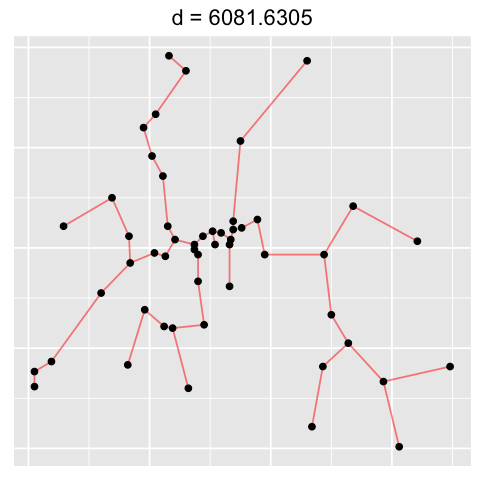

In [28]:
options(repr.plot.width = 4, repr.plot.height = 4)
y <- SolveMinimumSpanningTree(dist(berlin.52))
cbind(berlin.52[y[, 1], ], berlin.52[y[, 2], ]) %>% 
as.data.frame() %>%
ggplot() +
    geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
    geom_point(data = as.data.frame(berlin.52), aes(x = V1, y = V2)) +
    ggtitle(paste("d =", round(sum(as.matrix(dist(berlin.52))[y]), digits = 4))) + 
    theme(plot.title   = element_text(hjust = 0.5),
          axis.title.x = element_blank(),
          axis.text.x  = element_blank(),
          axis.ticks.x = element_blank(), 
          axis.title.y = element_blank(),
          axis.text.y  = element_blank(),
          axis.ticks.y = element_blank())

##### st.70

In [29]:
st.70 <- 
    "st70.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

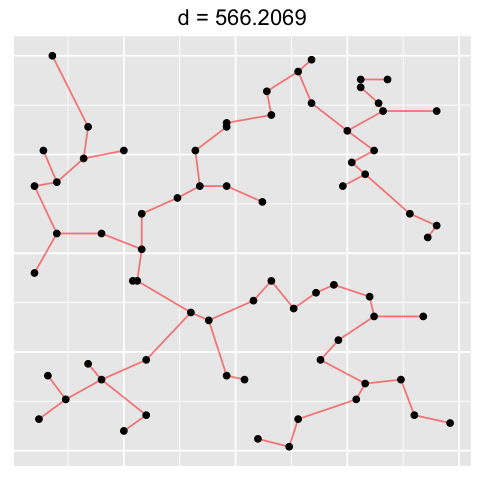

In [30]:
options(repr.plot.width = 4, repr.plot.height = 4)
y <- SolveMinimumSpanningTree(dist(st.70))
cbind(st.70[y[,1], ], st.70[y[,2], ]) %>% 
as.data.frame %>%
ggplot() +
    geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
    geom_point(data = as.data.frame(st.70), aes(x = V1, y = V2)) +
    ggtitle(paste("d =", round(sum(as.matrix(dist(st.70))[y]), digits = 4))) + 
    theme(plot.title   = element_text(hjust = 0.5),
          axis.title.x = element_blank(),
          axis.text.x  = element_blank(),
          axis.ticks.x = element_blank(), 
          axis.title.y = element_blank(),
          axis.text.y  = element_blank(),
          axis.ticks.y = element_blank())

##### a.280

In [31]:
a.280 <- 
    "a280.dat" %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()

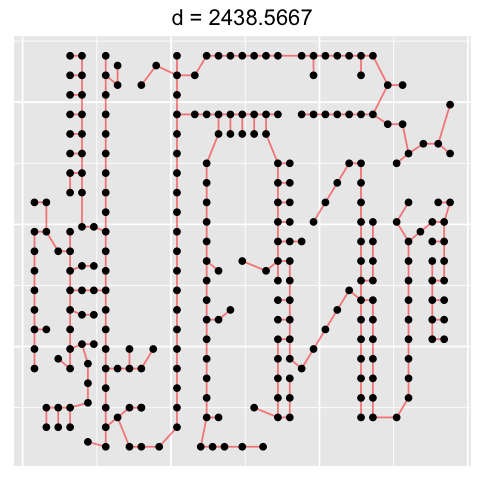

In [32]:
options(repr.plot.width = 4, repr.plot.height = 4)

y <- SolveMinimumSpanningTree(dist(a.280))
cbind(a.280[y[,1], ], a.280[y[,2], ]) %>% 
as.data.frame %>%
ggplot() +
    geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
    geom_point(data = as.data.frame(a.280), aes(x = V1, y = V2)) +
    ggtitle(paste("d =", round(sum(as.matrix(dist(a.280))[y]), digits = 4))) + 
    theme(plot.title   = element_text(hjust = 0.5),
          axis.title.x = element_blank(),
          axis.text.x  = element_blank(),
          axis.ticks.x = element_blank(), 
          axis.title.y = element_blank(),
          axis.text.y  = element_blank(),
          axis.ticks.y = element_blank())


##### gr15.{1,...,5}

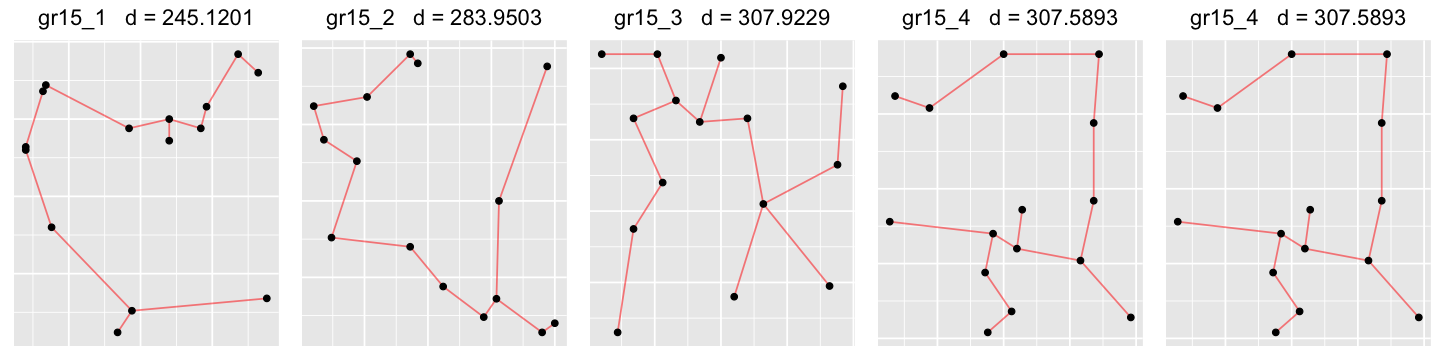

In [33]:
options(repr.plot.width = 12, repr.plot.height = 3)

gr.15 %>%
lapply(function(f) {
    p <- paste0(f, ".dat") %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()
    y <- SolveMinimumSpanningTree(dist(p))
    cbind(p[y[,1], ], p[y[,2], ]) %>% 
    as.data.frame %>%
    ggplot() +
        geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
        geom_point(data = as.data.frame(p), aes(x = V1, y = V2)) +
        ggtitle(paste(f, "  d =", round(sum(as.matrix(dist(p))[y]), digits = 4))) + 
            theme(plot.title   = element_text(hjust = 0.5),
                  axis.title.x = element_blank(),
                  axis.text.x  = element_blank(),
                  axis.ticks.x = element_blank(), 
                  axis.title.y = element_blank(),
                  axis.text.y  = element_blank(),
                  axis.ticks.y = element_blank())
}) %>%
{ do.call("grid.arrange", c(., ncol = 5)) }


### Árbol Recubridor Mínimo Capacitado

#### Descripción

El problema del árbol recubridor mínimo capacitado se refiere a un caso particular del problema del árbol recubridor mínimo. Este limita la cantidad de flujo que puede pasar por un arista a un determinado valor $k$. Lo que hace que la distancia del vértice de partida hasta el resto de vértices sea de un máximo de $k$. Este problema es mucho más difícil de resolver debido a la explosión combinatoria que surge al restringir el número de vértices en cada enlace con el vértice raiz.

#### Modelo

A continuación se muestra el modelo de programación linela que representa el problema del árbol recubridor mínimo con capacidades:

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{(i,j) \in A} c_{ij} \cdot y_{ij} \\
      \text{sujeto a}  & \sum\limits_{j} x_{1j} - \sum\limits_{j} x_{j1} = n(N) - 1 & \\
                       & \sum\limits_{j} x_{ij} - \sum\limits_{j} x_{ji} = - 1, & \forall i \in N - \{1\} \\
                       & x_{ij} - k \cdot y_{ij} \leq 0,  & \forall (i,j) \in A \\
                       & x_{ij} \geq 0, & \forall (i,j) \in A \\
                       & y_{ij} \in \{0, 1\},  & \forall (i,j) \in A
    \end{array}
\end{equation}

#### Ejemplos

En este caso, los ejemplos que se han resuelto han sido los utilizados anteriormente en el problema del árbol recubridor mínimo. Para estos, se ha resuelto el problema del árbol recubridor mínimo, utilizando como vértice raiz, el primero de ellos. Los problemas se han resuelto para $k \in \{1, .., n\}$. En este caso, debido a la dificultad combinatoria que surge al resolver este problema se ha recurrido al solver *xpress-mosel*. Tal y como se puede apreciar en los resultados, en cuanto $k$ toma valores en torno a 8, para todos los problemas se llega al árbol recubridor mínimo.

##### gr.15.{1,...,5}

In [34]:
gr.15  %>%
lapply(function(f) {
    p <- paste0(f, ".dat") %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()
    WriteListToMoselData(paste0(dataset.mosel, "mosel_input_", f, ".dat"), 
                         list(n = nrow(p), 
                              b = matrix(c(14, rep(-1, 14)), ncol = 1), 
                              A = as.matrix(dist(p)),
                              s = matrix(replace(rep(0, nrow(p)), c(2, 7, 11, 12, 15), 1), ncol = 1)))
}) %>%
invisible()

In [35]:
file.show(file = paste0(dataset.mosel, "cmst.mos"))

R Information

model "cmst"
    uses "mmxprs";
    declarations
        n: integer
        file_name = "gr15_1"
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        n
    end-initializations 
    declarations
        nodes = 1..n
        b: array(nodes) of real
        A: array(nodes, nodes) of real
        x: dynamic array(nodes, nodes) of mpvar
        y: dynamic array(nodes, nodes) of mpvar
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        b A
    end-initializations
    forall(i in nodes, j in nodes | A(i, j) <> 0) do
        create(x(i, j))
        create(y(i, j))
        y(i, j) is_binary
    end-do
    obj := sum(i in nodes, j in nodes | A(i, j) <> 0) y(i, j) * A(i, j) 
    forall(i in nodes) do
        res1(i) := sum(j in nodes) x(i, j) - sum(j in nodes) x(j, i) = b(i)
    end-do
    forall(u in 1..n) do
        forall(i in nodes, j in nodes | A(i, j) <> 0) do 
            res2(i, j) := x(i, j) - y(i, 

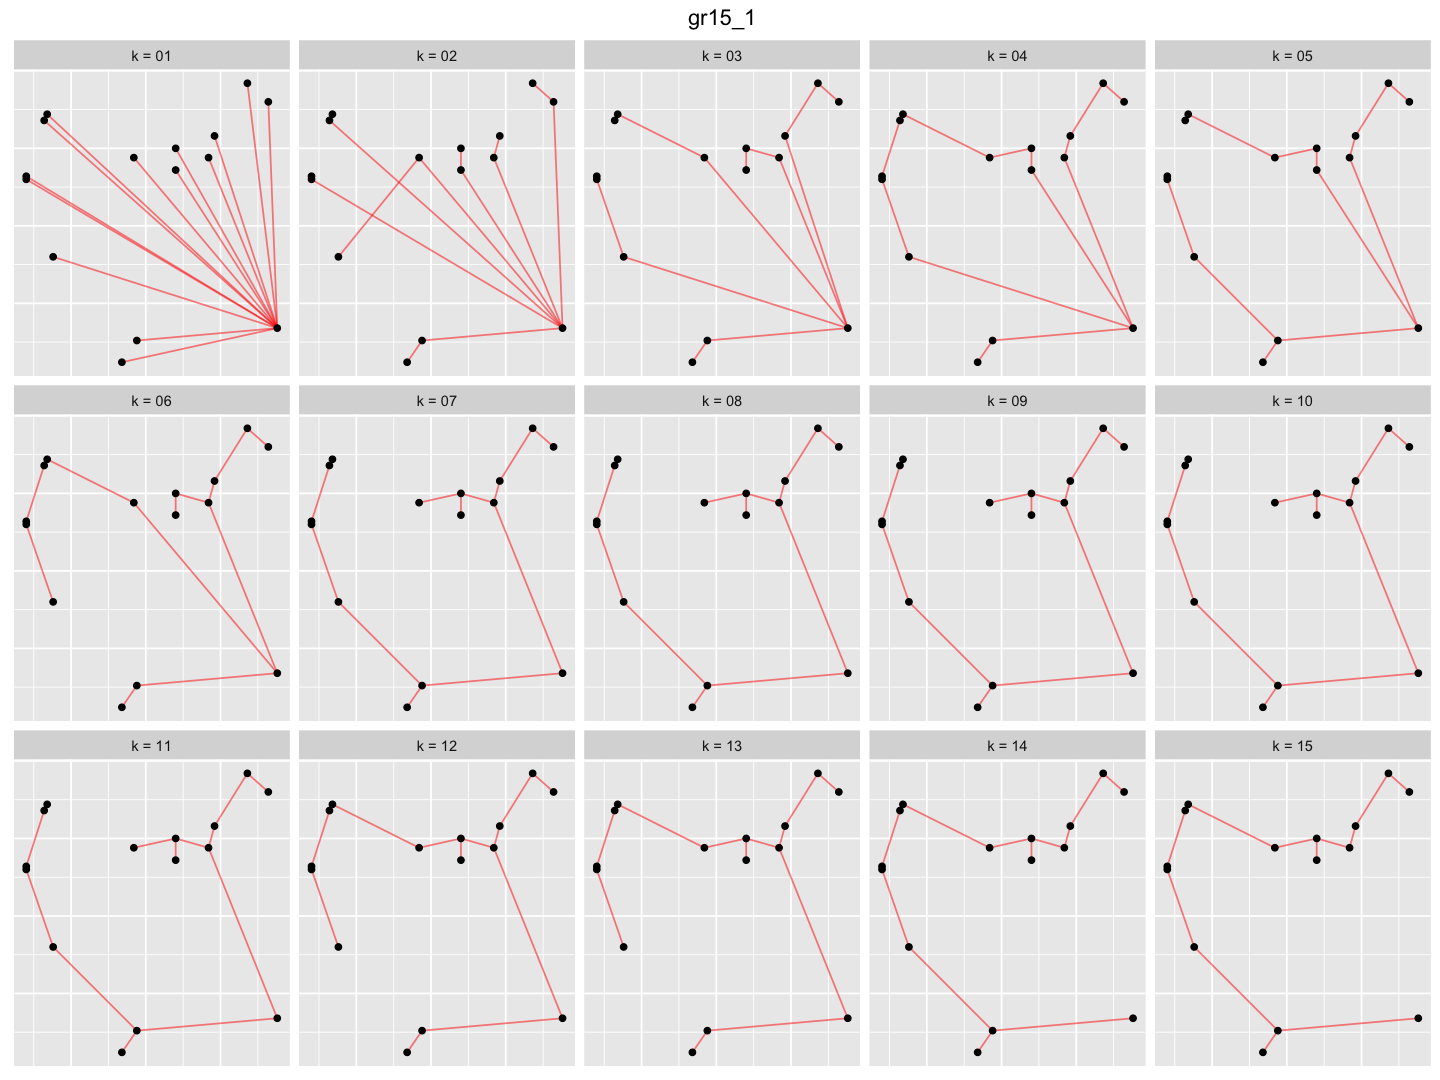

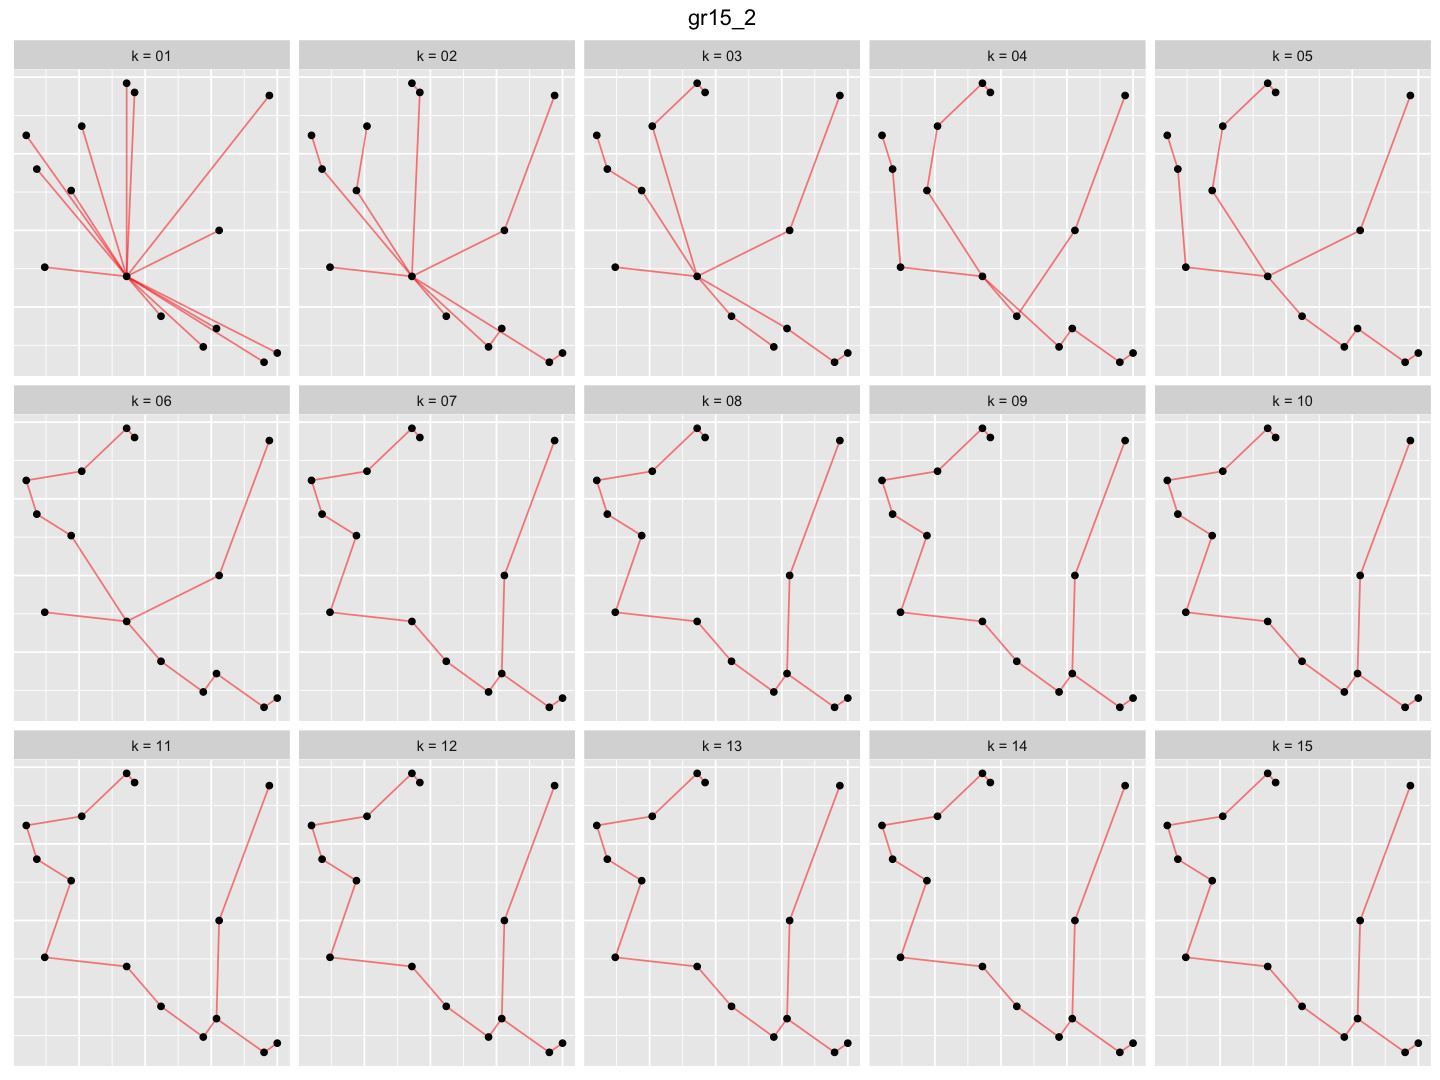

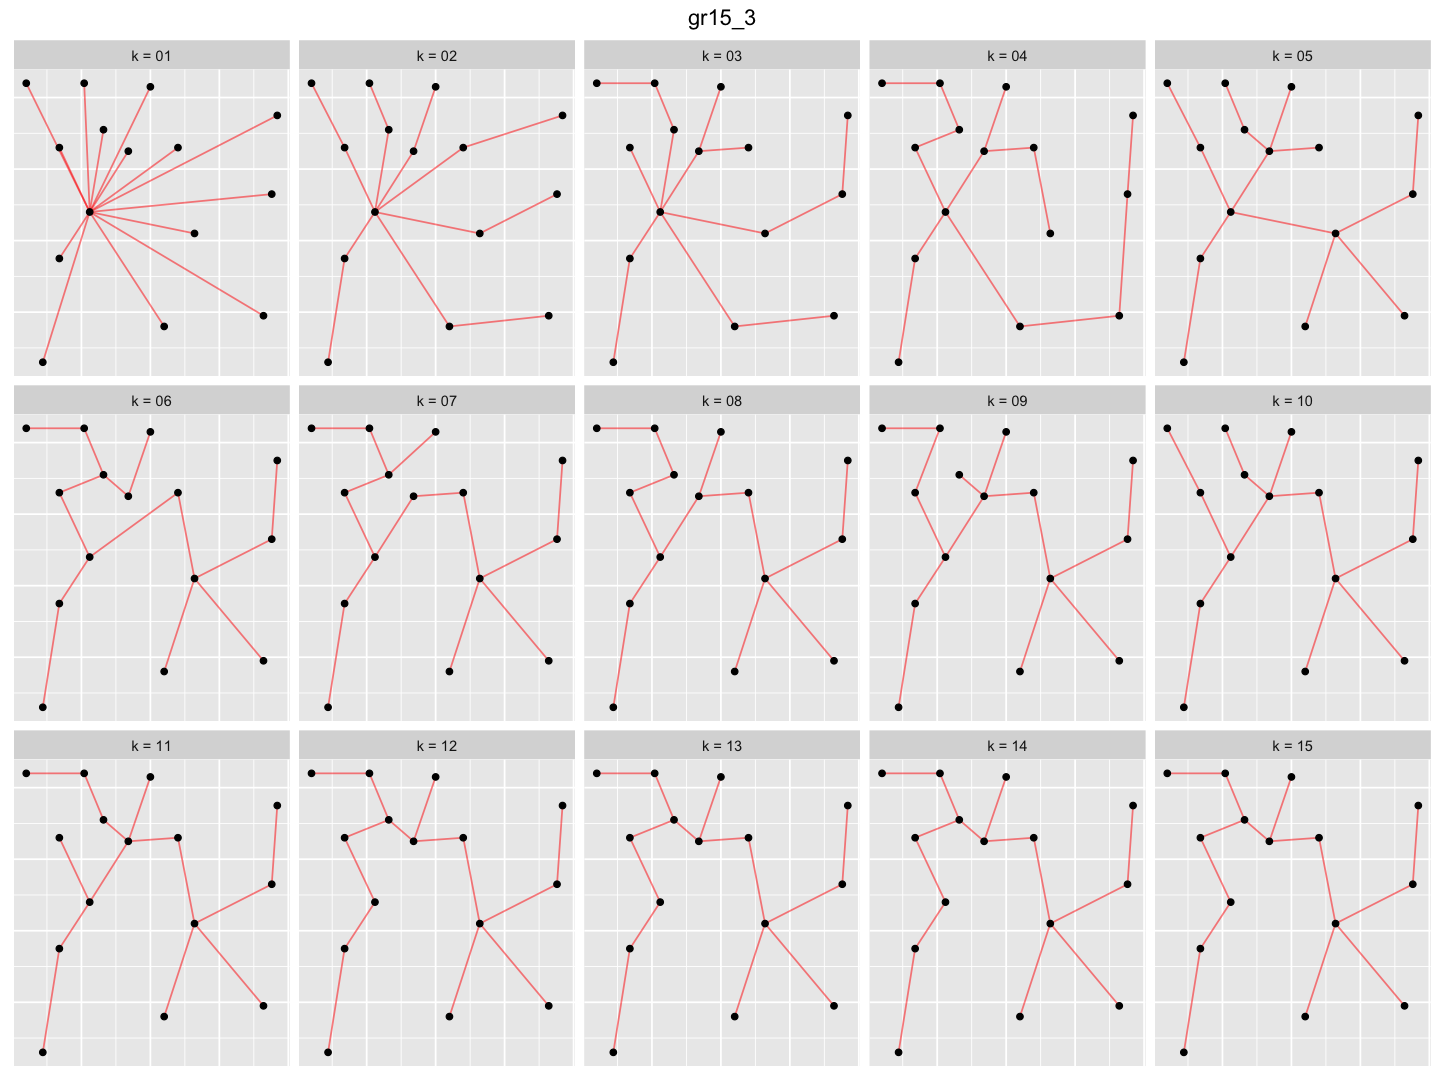

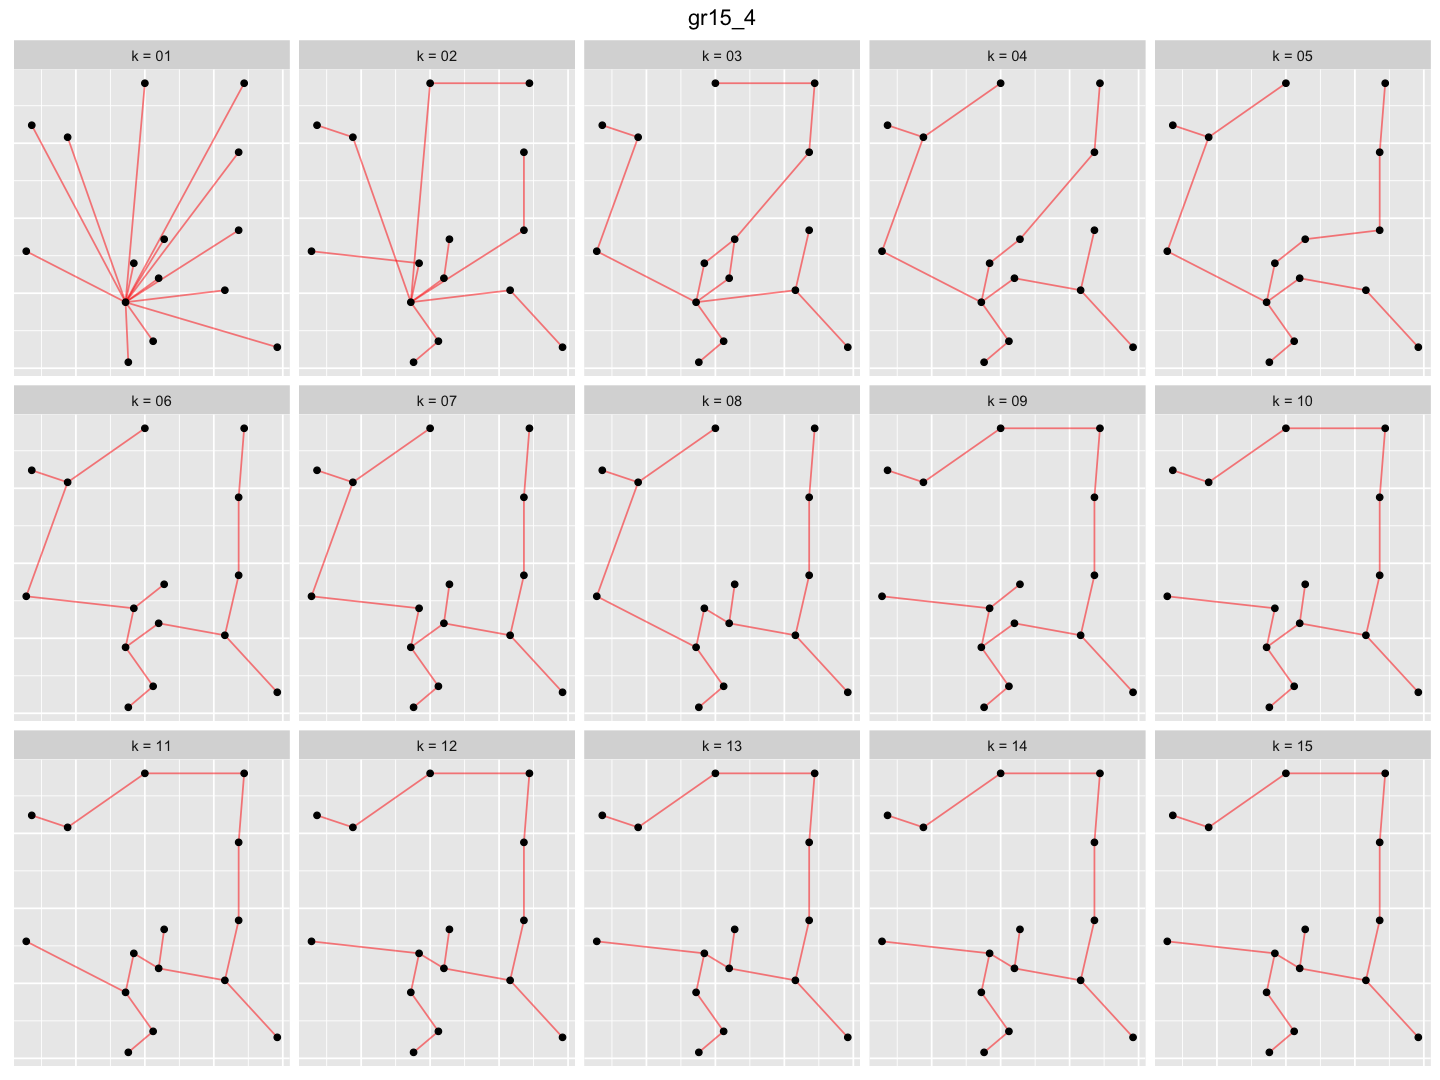

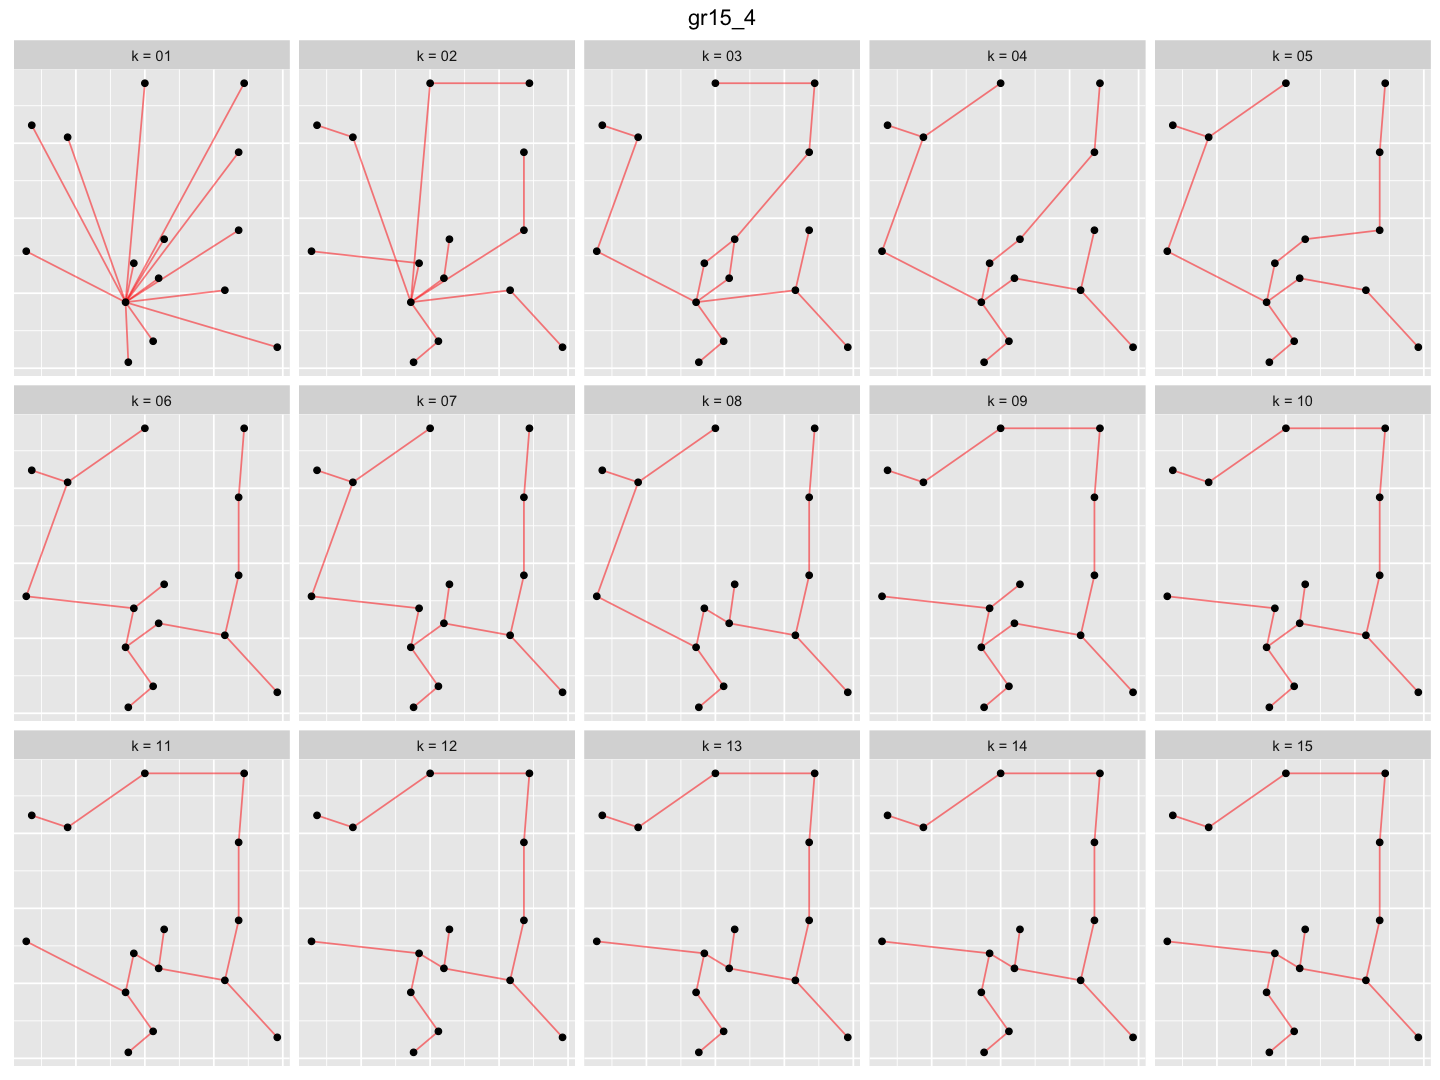

In [36]:
options(repr.plot.width = 12, repr.plot.height = 9)
gr.15  %>%
plyr::l_ply(function(f) {
    p <- paste0(f, ".dat") %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()
    seq(1, nrow(p)) %>% 
    lapply(function(n) {
        y <- paste0(dataset.mosel, "mosel_output_", f, "_", n, ".csv") %>%
            ReadEdgesList()
        cbind(p[y[,1], ], p[y[,2], ]) %>% 
        as.data.frame()
    }) %>% 
    map_df(I, .id = "k") %>%
    mutate(k = sprintf("k = %02d", as.numeric(k))) %>%
    ggplot() +
        geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red", alpha=0.5) +
        geom_point(data = as.data.frame(p), aes(x = V1, y = V2)) +
        facet_wrap(~ k, ncol = 5)  + 
        ggtitle(f) +
        theme(plot.title   = element_text(hjust = 0.5),
              axis.title.x = element_blank(),
              axis.text.x  = element_blank(),
              axis.ticks.x = element_blank(), 
              axis.title.y = element_blank(),
              axis.text.y  = element_blank(),
              axis.ticks.y = element_blank())
}, .print = TRUE) 

### Problema de Steiner

#### Descripción

El problema de steiner es otra caracterización basada en el problema del árbol contenedor mínimo. En este caso, sucede algo similar a lo que ya sucedía con el árbol recubridor mínimo capacitado en el sentido de la dificultad de resolución, ya que surge una explosión combinatoria debida a las distintas soluciones posibles. El problema se basa en la búsqueda de un árbol recubridor mínimo, pero en este caso basado en un subconjunto de vértices del grafo en lugar del grafo completo. De esta manera, hay vértices que no formarán parte del árbol de recubrimiento mínimo. Los vértices que si que forman parte pero no pertenecen al subconjunto que se pretende cubrir se denominan vértices de Steiner. El modelo es equivalente al del árbol recubridor mínimo. Sin embargo, en este caso, tan solo se pretende optimizar la distancia de los vértices contenidos en $S$. Por tanto, el resto de vértices actuarán como vértices de paso, y su demanda será $0$.

#### Modelo

A continuación se define el modelo de programación lineal que resuelve el problema de Steiner:

\begin{equation}
    \begin{array}{ll@{}ll}
      \text{Minimizar} & \displaystyle \sum\limits_{(i,j) \in S} c_{ij} \cdot y_{ij} \\
      \text{sujeto a}  & \sum\limits_{j} x_{S_{1}j} - \sum\limits_{j} x_{jS_{1}} = n(S) - 1 & \\
                       & \sum\limits_{j} x_{1i} - \sum\limits_{j} x_{ji} = 0, & \forall i \in N - S \\
                       & \sum\limits_{j} x_{ij} - \sum\limits_{j} x_{ji} = - 1, & \forall i \in S - \{1\} \\
                       & x_{ij} - n(S) \cdot y_{ij} \leq 0,  & \forall (i,j) \in A \\
                       & x_{ij} \geq 0, & \forall (i,j) \in A \\
                       & y_{ij} \in \{0, 1\},  & \forall (i,j) \in A
    \end{array}
\end{equation}

#### Ejemplos

A continuación se muestran los resultados del problema de steiner sobre distintos conjuntos de datos. En concreto, se ha utilizado un problema basado en 11 componentes eléctricos, del cual se pretende interconectar de la manera más eficiente 5 de ellos, utilizando el resto como vértices de unión o de Steiner. Además, se ha resuelto el problema de Steiner sobre los conjuntos de datos *gr.15* utilizados anteriormente. Estos probelmas han sido resueltos utilizando el solver *xpress-mosel* junto con el script que se describe a continuación.

In [37]:
file.show(file = paste0(dataset.mosel, "steiner.mos"))

R Information

model "cmst"
    uses "mmxprs";
    declarations
        n: integer
        file_name = "components_11"
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        n
    end-initializations 
    declarations
        nodes = 1..n
        b: array(nodes) of real
        A: array(nodes, nodes) of real
        s: array(nodes) of real
        x: dynamic array(nodes, nodes) of mpvar
        y: dynamic array(nodes, nodes) of mpvar
    end-declarations
    initializations from "mosel_input_" + file_name + ".dat"
        A s
    end-initializations
    
    stnr := sum(i in nodes) s(i) 
    ii := 1
    while(s(ii) = 0 and ii < n )do
        ii := ii + 1
    end-do
    b(ii) := stnr - 1
    forall(i in (ii + 1)..n | s(i) <> 0) do
        b(i) := -1
    end-do
    forall(i in nodes, j in nodes | A(i, j) <> 0) do
        create(x(i, j))
        create(y(i, j))
        y(i, j) is_binary
    end-do
    forall(i in nodes) do
        res1(i) := sum(j in nod

##### grafo.11.nodos

In [38]:
WriteListToMoselData(
    paste0(dataset.mosel, "mosel_input_components_11.dat"), 
    list(n = 11, 
         A = matrix(c(  0, 14, 0, 0, 0, 4, 0, 0, 0, 0, 0,
                       14,  0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
                        0,  0, 0, 9, 0, 0, 0, 0, 2, 0, 0,
                        0,  0, 9, 0, 0, 0, 0, 0, 0, 3, 6,
                        0,  0, 0, 0, 0, 0, 0, 5, 0, 0, 3,
                        4,  0, 0, 0, 0, 0, 9, 0, 3, 0, 0,
                        0,  0, 0, 0, 0, 9, 0, 2, 0, 3, 0,
                        0,  3, 0, 0, 5, 0, 2, 0, 0, 0, 0,
                        0,  0, 2, 0, 0, 3, 0, 0, 0, 8, 0,
                        0,  0, 0, 3, 0, 0, 3, 0, 8, 0, 0,
                        0,  0, 0, 6, 3, 0, 0, 0, 0, 0, 0)
                    , ncol = 11, byrow = TRUE),
            s = matrix(replace(rep(0, 11), 1:5, 1), ncol = 1)))

In [39]:
y <- paste0(dataset.mosel, "mosel_output_components_11_steiner.csv") %>%
    ReadEdgesList()
cbind(LETTERS[y[,1]], LETTERS[y[,2]])

A,F
F,I
G,H
H,B
H,E
I,C
I,J
J,D
J,G


##### gr.15.{1,...,5}

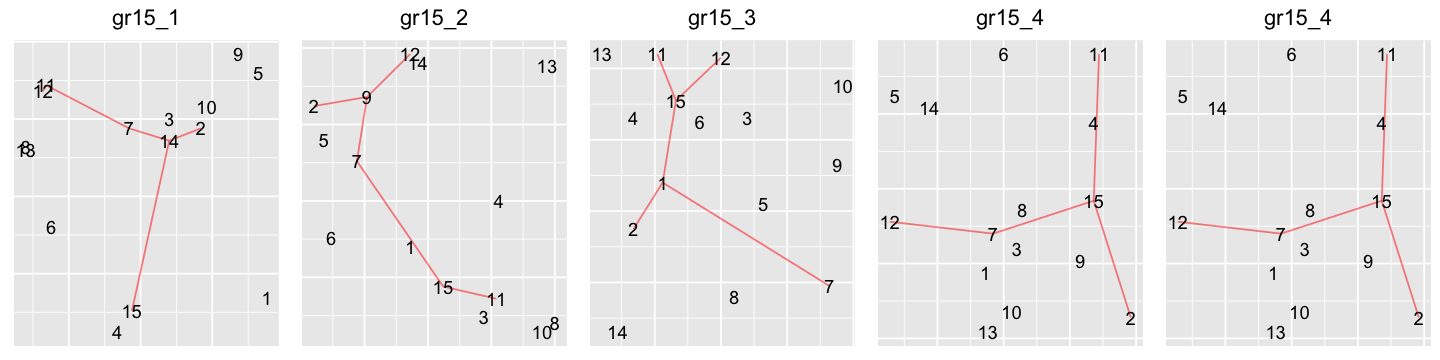

In [40]:
options(repr.plot.width = 12, repr.plot.height = 3)
gr.15 %>%
lapply(function(f) {
    p <- paste0(f, ".dat") %>%
    { paste0(dataset.folder, .) } %>%
    ReadCoordinatedFile()
    y <- paste0(dataset.mosel, "mosel_output_", f, "_steiner.csv") %>%
        ReadEdgesList()
    cbind(p[y[,1], ], p[y[,2], ]) %>% 
    as.data.frame %>%
    ggplot() +
        geom_segment(aes(x = V1, y = V2, xend = V3, yend = V4),colour="red",alpha=0.5) +
        geom_text(data = as.data.frame(p), aes(x = V1, y = V2, label = 1:nrow(p))) +
        ggtitle(f) +
            theme(plot.title   = element_text(hjust = 0.5),
                  axis.title.x = element_blank(),
                  axis.text.x  = element_blank(),
                  axis.ticks.x = element_blank(), 
                  axis.title.y = element_blank(),
                  axis.text.y  = element_blank(),
                  axis.ticks.y = element_blank())
}) %>%
{ do.call("grid.arrange", c(., ncol = 5)) }


## Conclusiones

Tal y como se ha podido apreciar a lo largo de este trabajo, el estudio de los problemas de redes tiene grandes aplicaciones que permiten modelizar situaciones reales, reduciendo tiempo y costes. En este caso, el área de aplicación principal es el del transporte de mercancias y la construcción de redes de transporte. Sin embargo, estos problemas se pueden aplicar a otras situaciones similares, como el diseño de redes de computadoras u otras áreas de interés.

Entre los problemas estudiados, el más general es el de flujo de redes con costos fijos. Dicha modelización permite representar un gran número de situaciones de manera sencilla, por lo que el dominio de la misma es esencial. Sin embargo, de entre los descritos, el problema más estudiado es el del árbol recubridor mínimo. Este destaca sobre el resto debido a su resolución en tiempo polinómico (mediante algoritmos como el de Kruskal o Prim). Sin embargo, es necesario analizar otros problemas más generales como el de Steiner, que permiten una mayor capacidad de modelización.

El estudio de heurística que permitan resolver dichos problemas, para los que una solución óptima con costes computacionales polinómicos no existe, pero que sin embargo puede ser aproximada con alta precisión es un área interesante de investigación, y para el cual existe una basta cantidad de literatura.

## Referencias

  * [TRC13] Team, R.C., 2013. R: A language and environment for statistical computing.
  * [GP18] Sergio García Prado. Programación Entera: Heurísticas, 2018. [github.com/garciparedes/integer-programming-heuristics](https://github.com/garciparedes/integer-programming-heuristics).
  * [SA18] Jesús Sáez Aguado. Programación Entera, 2017/18. Facultad de Ciencias: Departamento de Estadística e Investigación Operativa.
  * [THBSST17] Theussl, S., Hornik, K., Buchta, C., Schwendinger, F., Schuchardt, H. and Theussl, M.S., 2017. Package ‘Rglpk’.
  * [FIC] FICO Xpress. Xpress-Mosel. http://www.maths.ed.ac.uk/hall/Xpress/FICO_Docs/mosel/mosel_lang/dhtml/moselref.html/